In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import os
import time
import json

%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.7"
    ! pip install -q "matplotlib==3.5.3"
    ! pip install -q "astropy==6.0.0"
    from gwpy.timeseries import TimeSeries    

from gwpy.signal import filter_design

from scipy.stats import entropy, kurtosis, skew

from IPython.display import clear_output


In [5]:
import qiskit  
import qiskit.visualization 
from qiskit.circuit.library import *
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.neural_networks import SamplerQNN

<h1> Retrieval & Processing of the Data, and feature selections for the QAE

Autoencoders compress input features into a lower-dimensional latent space and then reconstruct them. The latent space acts as a bottleneck, forcing the model to learn the most important features. By training the autoencoder to minimize reconstruction errors on anomaly-free dataset, we can identify anomalies, in our case gravitational waves, as events with significantly higher reconstruction errors. 

We download from the JSON file provided by the GWOSC (gravitational waves open science center) 50 samples of time series where gravitational waves have been detected :

In [6]:
def downloadData(filename, sizeOfDataset) :
    with open(filename,'r') as file :
        dataset = json.load(file)
    
    rawData = []
    t0List = []
    
    #the URLs in the file of GW detection are values stored in dictionary
    for key in list(dataset["events"].keys())[:sizeOfDataset] :
        json_url = dataset["events"][key]["jsonurl"]
        #dataset["events"][key]["GPS"] is the time of detection
        timeOfDetection = dataset["events"][key]["GPS"]
        t0List.append(timeOfDetection - 5)

        json_response = requests.get(json_url)
        json_file = json_response.json()
        url = json_file["events"][key]["strain"][1].get("url")

        toDownload = os.path.basename(url)
        rawData.append(toDownload)
        with open(toDownload,'wb') as strainfile :
            straindata = requests.get(url)
            strainfile.write(straindata.content)
        
    return rawData, t0List

validationGW_rawData, validationGW_times = downloadData("ligoEvents.customization", 50) 

In [7]:
def getTimeSeries(raw_data, time_data) :
    listOfTimeSeries = []
    n = len(raw_data)
    for k in range(n) :
        ts = TimeSeries.read(raw_data[k], format='hdf5.gwosc', end=time_data[k]+12)
        #cleaning the data : getting rid of nan values
        new_ts = TimeSeries(
        ts[~np.isnan(ts)], 
        t0=ts.t0,
        dt=ts.dt,
        name=ts.name,
        channel=ts.channel,
    )
        t0 = time_data[k]
        new_ts = new_ts.crop(t0 + 1, t0 + 9)
        listOfTimeSeries.append(new_ts)
    return listOfTimeSeries

validationGW_TS = getTimeSeries(validationGW_rawData, validationGW_times)

To train our Quantum Autoencoder (QAE), we will need data where gravitational waves haven't been detected. One approach would be to use data collected from July 2009 to October 2010 (LIGO Dataset S6) since gravitational waves have only been detected after 2015, but the equipment used  during this period is less advanced and more prone to noise than the one used to detect gravitational waves (GWs) for the first time (LIGO upgraded to advancedLIGO - aLIGO - in 2014). We will need thus to retrieve data from aLIGO measures between the first (15th september 2015) and second (26th december 2015) instances where GWs where detected to build our anomaly-free dataset.

We now get the time series for the samples without gravitational waves with the Timeseries.fetch_open_data method :

In [ ]:
trainingTS =[]


gpsStart = 1126313984 #time of the first recording of 15th Sept
n = 0
while n < 100 :
    ts = TimeSeries.fetch_open_data('H1', gpsStart, gpsStart + 8) 
    trainingTS.append(ts)
    gpsStart += 120
    n += 1


In [187]:
validationNonGW_TS = []

gpsStart = 1126314034 #1126313984 + 50
n = 0
while n < 50 :
    ts = TimeSeries.fetch_open_data('H1', gpsStart, gpsStart + 8) 
    validationNonGW_TS.append(ts)
    gpsStart += 120
    n += 1

Now, we filter some of the main frequencies that introduce noise in the sample as indicated in Ligo guidelines (cf O1 Instrumental lines), like the harmonics of power lines frequency in the US (60 Hz), or noise due to the instruments used in LIGO.

In [188]:
def filtering(timeSeriesList) :
    filteredList = []
    for ts in timeSeriesList :
        sampleRate = ts.sample_rate
        noiseFrequencies = (60, 120, 180, 500, 1000, 300, 600, 900)
        notches = [filter_design.notch(frequency, sampleRate) for frequency in noiseFrequencies]
        finalFilter = filter_design.concatenate_zpks(*notches)
        filteredTS = ts.filter(finalFilter, filtfilt = True)
        filteredTS = filteredTS.crop(*filteredTS.span.contract(1))
        filteredList.append(filteredTS)
    return filteredList


In [189]:
training_fts = filtering(trainingTS)
validationGW_fts = filtering(validationGW_TS)
validationNonGW_fts = filtering(validationNonGW_TS)

In [191]:
def frequencyData(timeSeriesList) :
    asd = []
    for ts in timeSeriesList :
        sg = ts.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
        #we take the media to capture the central tendancy
        median = sg.percentile(50)
        asd.append(median)
    return asd


c:\Python312\Lib\site-packages\gwpy\plot\plot.py:297: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


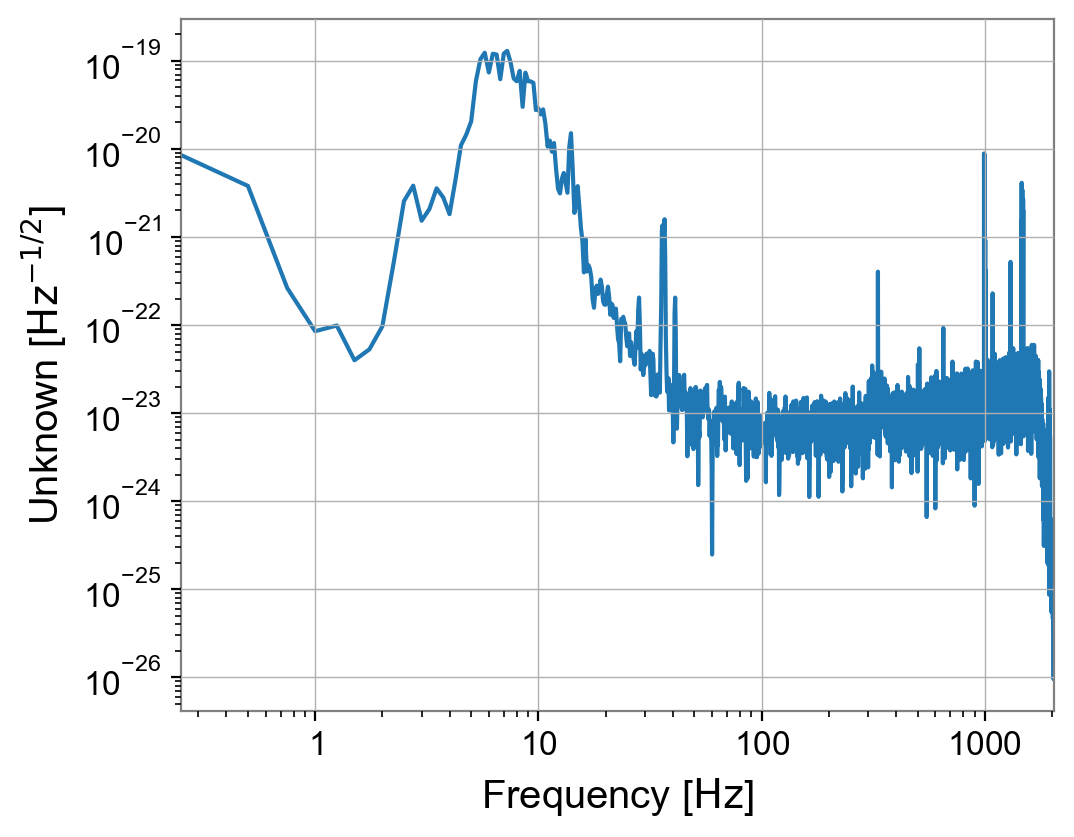

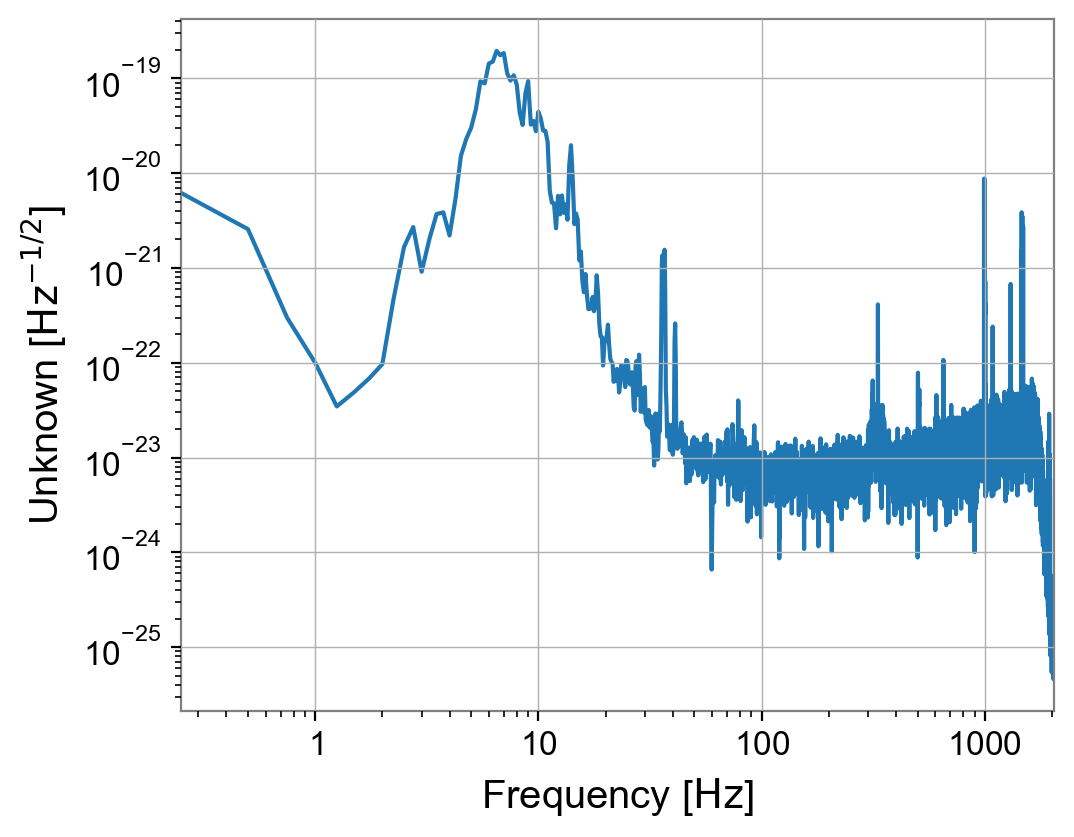

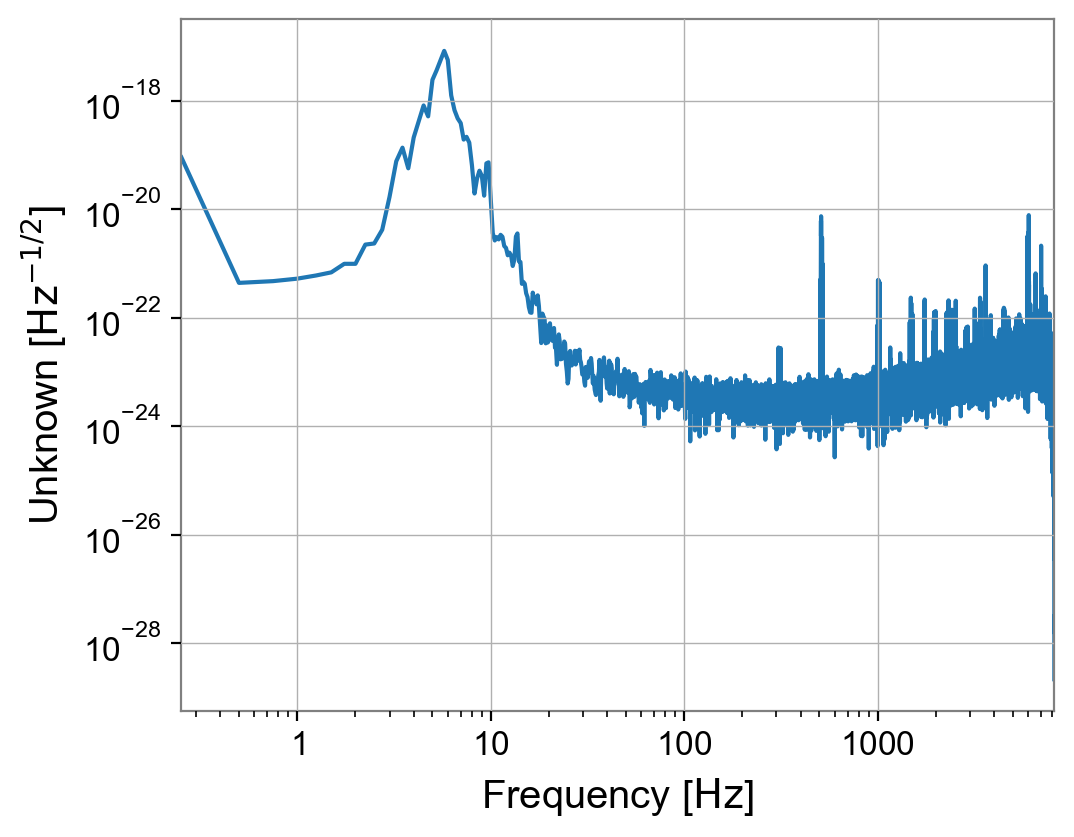

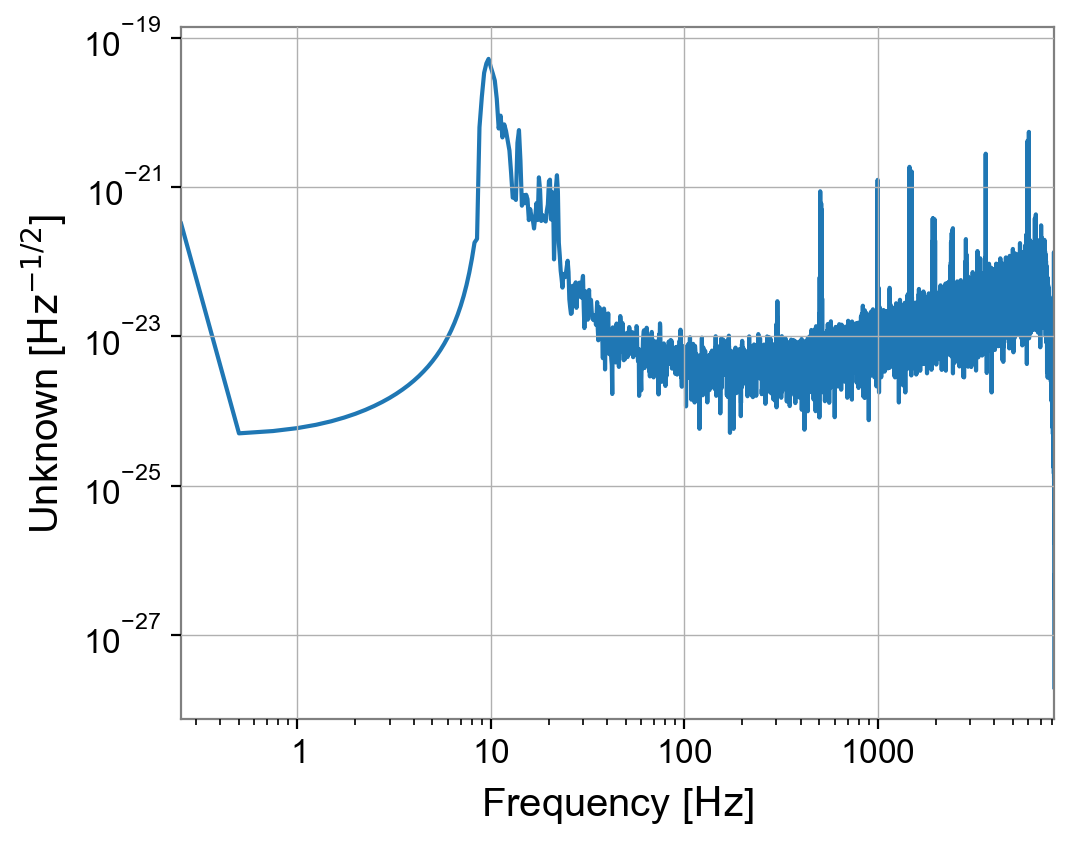

In [192]:
freqTraining = frequencyData(training_fts)
freqGW = frequencyData(validationGW_fts)
freqNoGW = frequencyData(validationNonGW_fts)


t_0, t_1 = freqTraining[0], freqTraining[1]
gw_0, gw_1 = freqGW[0], freqGW[1]
t0 = t_0.plot(xscale="log", yscale="log")
t1 = t_1.plot(xscale="log", yscale="log")
gw0 =gw_0.plot(xscale="log", yscale="log")
gw1 =gw_1.plot(xscale="log", yscale="log")

t0.show()
t1.show()
gw0.show()
gw1.show()

From these plots, we choose statistical indicators to see if the values associated to anomalous data and data with no GWs are different, thus indicating that our quantum autoencoder will struggle to reconstruct it. We calculate those from 15Hz onwards because the data is unreliable below this frequency.

In [193]:
print("no GW :", entropy(t_0.value[60:]), kurtosis(t_0.value[60:]), skew(t_0.value[60:]))
print("no GW :", entropy(t_1.value[60:]), kurtosis(t_1.value[60:]), skew(t_1.value[60:]))
print("GW :", entropy(gw_0.value[60:]), kurtosis(gw_0.value[60:]), skew(gw_0.value[60:]))
print("GW :", entropy(gw_1.value[60:]), kurtosis(gw_1.value[60:]), skew(gw_1.value[60:]))


no GW : 6.609179612649762 439.5701437211159 19.22308416329889
no GW : 6.629275273089692 459.36711785703744 19.67324477529443
GW : 9.44286594648534 2607.79784933829 46.742175616163685
GW : 9.886831938257695 1624.878238109029 31.486269410170667


We see that the values are indeed quite different between the two situations, to have a more complete feature set, we can also take into the ratio of the maximum ammplitude of the signal to the mean of the signal, and an approximation of the signal to noise ratio by taking the ration of the mean amplitude of the signal and the standard deviation of the noise which we conveniently approximate to be the same as the standard deviation of the frequency signal itself.

<h1> Retrieving features

In [197]:
def features(freqSeriesList) :
    dataFeatures = []
    for fs in freqSeriesList :
        array = fs.value[60:] #slicing to discard data below 15Hz
        e = entropy(array) 
        k = kurtosis(array)
        s = skew(array)
        mean = np.mean(array)
        snr = mean/np.std(array)
        ratio = max((array))/mean
        dataFeatures.append([e, k, s, snr, ratio])
    
    dataFeatures = np.array(dataFeatures)
    #normalizing the data for angle embedding
    maximum = np.ones(5)
    for i in range(5) :
        maximum[i] = np.max(np.abs(dataFeatures[:, i]))
    for j in range(len(dataFeatures)) :
        for k in range(5) :
            dataFeatures[j][k] = dataFeatures[j][k] * 2*np.pi /maximum[k]

    return dataFeatures

In [206]:
trainingQData = features(freqTraining)
GWQData = features(freqGW)
NonGWQData = features(freqNoGW)

We now have our classical data, so we have to encode into quantum data that can serve as an input to our circuit. We use angle embedding which encodes the classical data as the angle of a rotation applied to the state $\ket{0}^{\otimes{5}}$

In [207]:
def angleEmbedding(featureArray) :
    angle1 = featureArray[0]/2
    c, s = np.cos(angle1), np.sin(angle1)
    tensorProduct = Statevector(np.array([c, s])) 
    for i in range(1, len(featureArray)) :
        angle = featureArray[i]/2
        c, s = np.cos(angle), np.sin(angle)
        tensorProduct = tensorProduct.tensor(Statevector(np.array([c, s])))
    return tensorProduct



<h1> Building the quantum autoencoder<h1>

Quantum autoencoders (QAEs) are quantum circuits that aim to compress classical data into a lower-dimensional quantum state and then reconstruct it. Unlike classical autoencoders, QAEs cannot directly achieve data compression through unitary transformations alone because quantum information cannot be lost. To overcome this limitation, QAEs produces a trash space, a collection of certain qubits that will be discarded to be replaced by a set of fixed reference states, generally $\ket{0}^{\otimes {d}}$, which carry no information on the input. Therefore, the closer the trash space is to the reference space, the better the compression : this comparison is carried out by calculating the fidelity between these two spaces, which is computed with the SWAP Test we implement few code blocks below.

We now initialize the circuit :

In [208]:
def circuitInput(featureArray) :
    entry = angleEmbedding(featureArray)
    circuit = qiskit.QuantumCircuit(5, 1)
    circuit.initialize(entry , range(0, 5, 1))
    circuit.barrier()
    return circuit


Now we build our variational circuits, we will implement two of them, one adapted from the paper "Anomaly detection in high-energy physics using a quantum autoencoder" with CNOT gates as entanglement blocks, and another with more rotations gates inspired from the paper "Quantum autoencoders with enhanced data encoding" (cf. references section) with CZ gates as entanglement blocks.

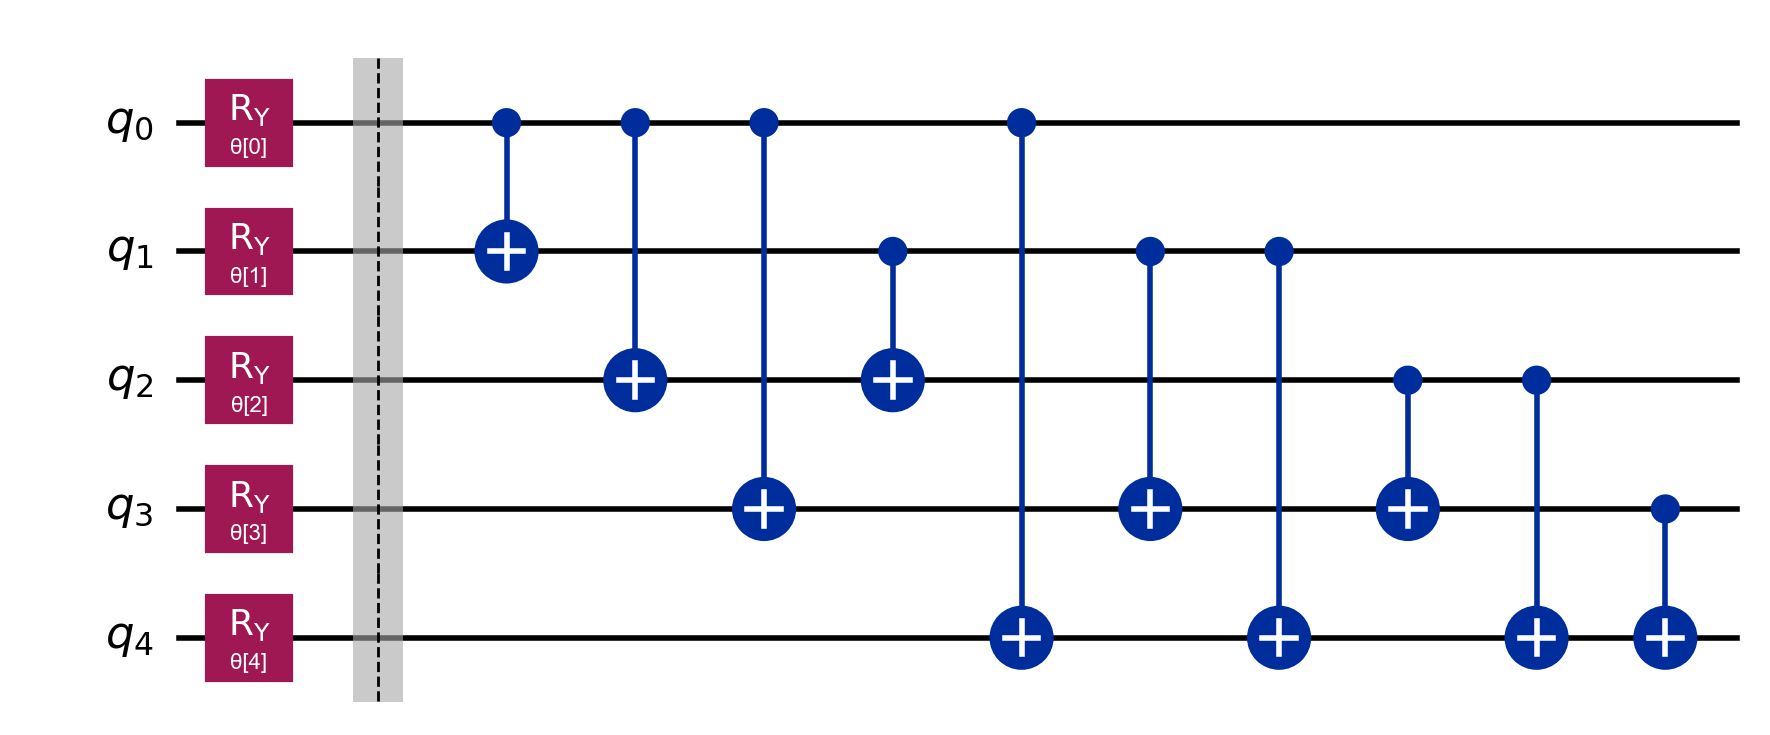

In [209]:
def vqc1() : 
    circuit = qiskit.QuantumCircuit(5)
    paramVector = ParameterVector('θ', 5)
    for i in range(5) :
        circuit.ry(paramVector[i], i)
    circuit.barrier()
    for i in range(5) :
        for j in range(i+1, 5) :
            circuit.cx(i, j)

    

    return circuit

vqc1().draw(output="mpl")


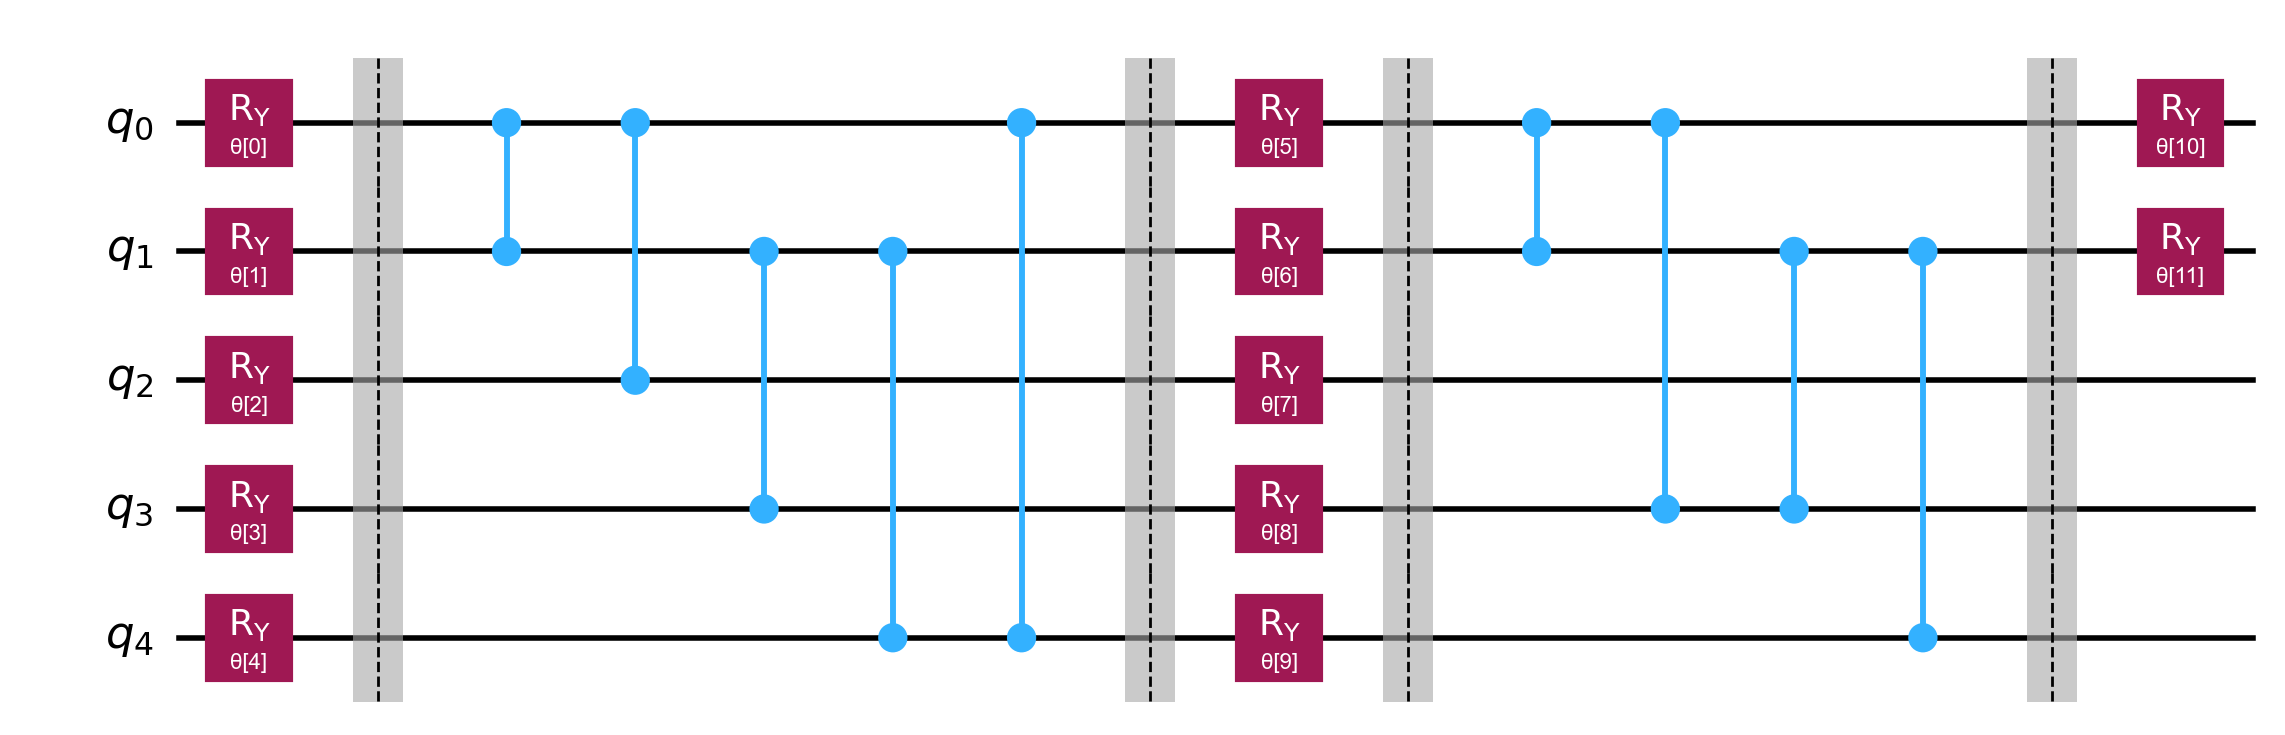

In [210]:
def vqc2() : 
    circuit = qiskit.QuantumCircuit(5)
    paramVector = ParameterVector('θ', 12) 
    for i in range(5) :
        circuit.ry(paramVector[i], i)
    circuit.barrier()

    circuit.cz(0, 1)
    circuit.cz(0, 2)
    circuit.cz(1, 3)
    circuit.cz(1, 4)
    circuit.cz(0, 4)
    circuit.barrier()
    

    for i in range(5) :
        circuit.ry(paramVector[i+5], i)
    circuit.barrier()


    circuit.cz(0, 1)
    circuit.cz(0, 3)
    circuit.cz(1, 3)
    circuit.cz(1, 4)
    circuit.barrier()

    circuit.ry(paramVector[10], 0)
    circuit.ry(paramVector[11], 1)

    return circuit

vqc2().draw(output="mpl")



We then go on to build the quantum autoencoder, by combining the circuit that initializes the qubits to the quantum state corresponding to the feature array, the variational circuit, and the SWAP test which allows us to quantify how similar two quantum states are : $\ket{1}$ signifying that the states are completely different, and $\ket{0}$ that they are identical. We quantify how accurate is the encoding part of the quantum autoencoder by comparing the trash state to a reference state set to $\ket{0}^{\otimes{2}}$ (2 being the size of our trash space) the closer the two states, the more successful our compression. So we will use later the probability of getting $\ket{1}$ as our cost function, the goal being to minimize it.

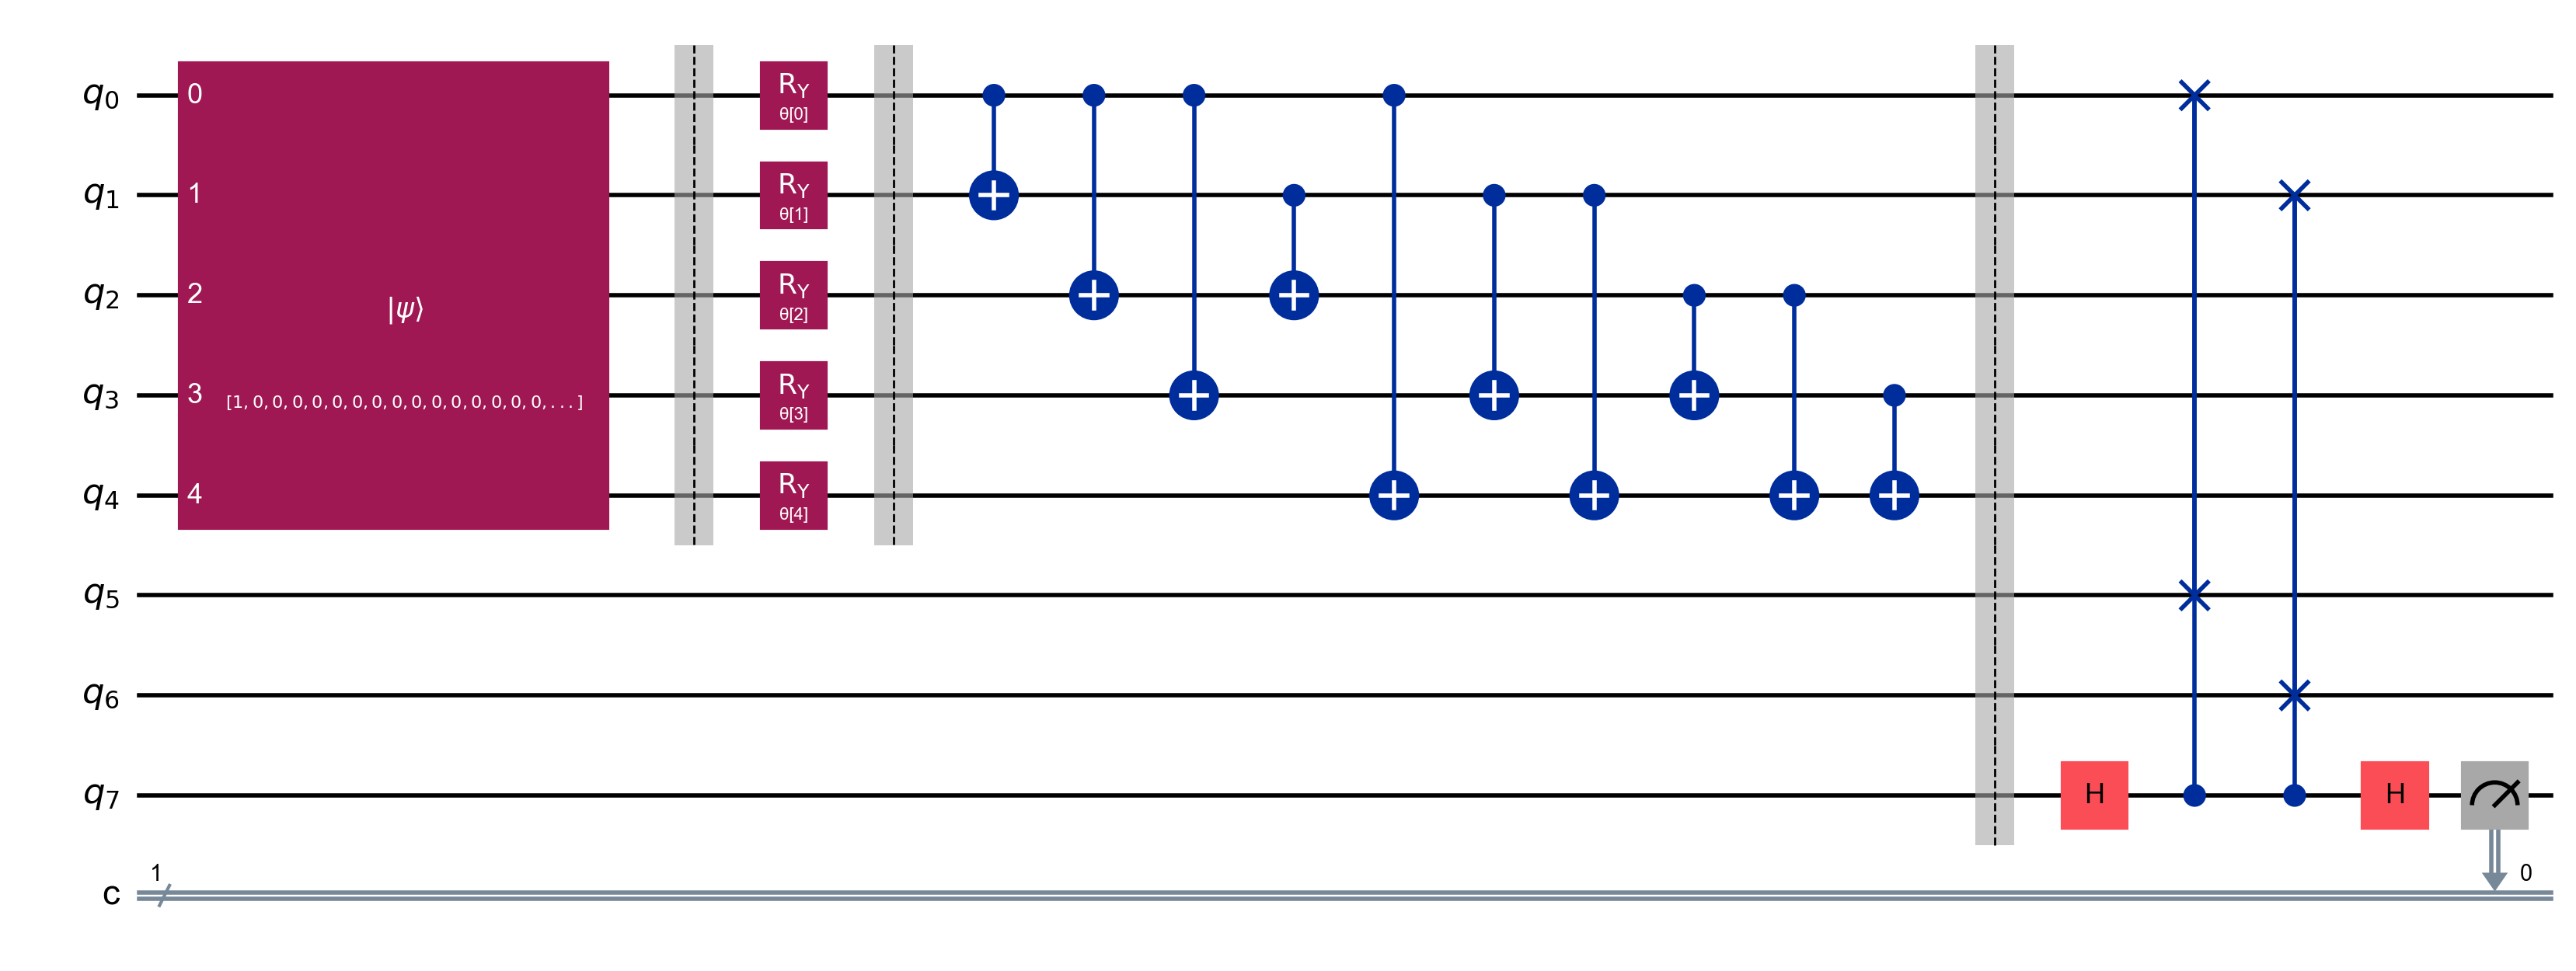

In [211]:
def autoEncoder(vqc, featureArray) :
    qr = qiskit.QuantumRegister(8, "q")
    cr = qiskit.ClassicalRegister(1, "c")
    circuit = qiskit.QuantumCircuit(qr, cr)
    #initializing the circuit with values from embedding
    circuit.compose(circuitInput(featureArray), range(0, 5), inplace = True)
    
    #combine vqc with this circuit
    circuit.compose(vqc(), range(0, 5), inplace = True) 
    circuit.barrier()

    #swap test
    aux = 7 #auxiliary qubit
    circuit.h(aux)
    #the first 2 qubits form the trash space
    circuit.cswap(aux, 0, 5)
    circuit.cswap(aux, 1, 6)
    circuit.h(aux)
    circuit.measure(aux, cr[0])
    return circuit

autoEncoder(vqc1, [0,0,0,0,0]).draw(output = "mpl")

    
    


Since we need to get the probability of getting $\ket{1}$, we use a sampler provided by the SamplerQNN class of qiskit, which is a classical neural-network wrapper for our variational circuit, allowing us to sample the probabilies distribution. We have to define an interpret functions, which tells the sampler how to map the quantum output to meaningful interpretations, for our case we need the probabilities for the outputs  $\ket{0}$ and $\ket{1}$ so we will just use the identity function.

In [212]:

def identity(x) :
    return x

def qnn1(featureArray) :
    ae = autoEncoder(vqc1, featureArray)
    qnn =  SamplerQNN(
    circuit = ae,
    input_params = [],
    weight_params = ae.parameters,
    interpret  = identity,
    output_shape = 2
)
    return qnn
    
def qnn2(featureArray) :
    ae = autoEncoder(vqc2, featureArray)
    qnn =  SamplerQNN(
    circuit = ae,
    input_params = [],
    weight_params = ae.parameters,
    interpret  = identity,
    output_shape = 2
)
    return qnn



For our cost function, we take the probability of the outcome $\ket{1}$ which is the output of the SWAP test which corresponds to the situation where the trash space and reference space are different ($\ket{0}$ means they are identical), so we seek to minimize that probability (our cost function) in order to have a trash space as similar as possible to reference space $\ket{0}^{\otimes 2}$

In [213]:
cost_function = []


def costFunction(qnn, dataset, parameters) :
    cost = 0
    for featureArray in dataset :
        probability = qnn(featureArray).forward([], parameters)
        cost += probability[0][1]
    
    cost = cost/len(dataset)
    cost_function.append(cost)
    print(cost_function[-1])
    clear_output(wait=True)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(cost_function)), cost_function)
    plt.show()

    return cost
    

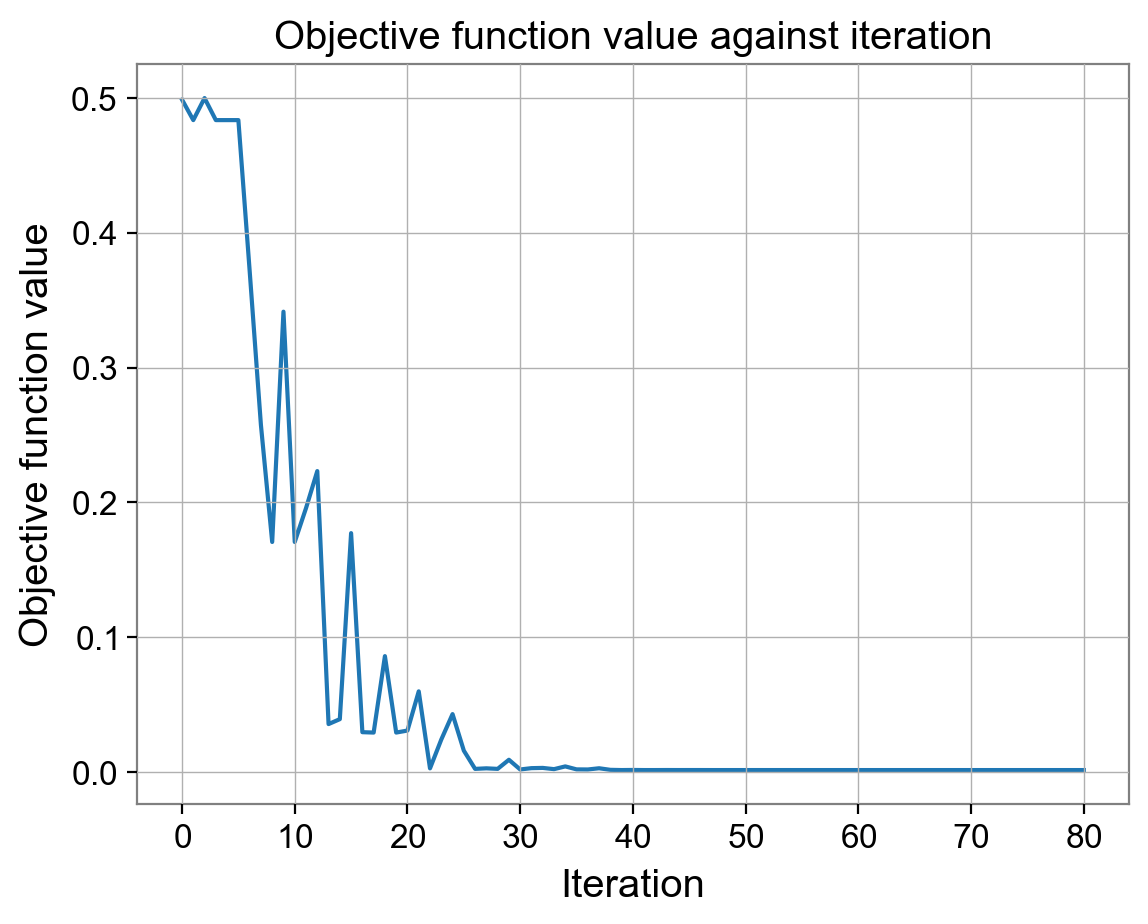

Fit in 70.30 seconds


In [214]:
def optimizationLoop(qnn, dataset, num_params) :
    cobyla = COBYLA(maxiter = 100)
    initial_params = [2*np.pi*np.random.rand() for k in range(num_params)]
    
    start = time.time()
    result = cobyla.minimize(
    fun=lambda parameters: costFunction(qnn, dataset, parameters), 
    x0=initial_params
    )
    time_elapsed = time.time() - start
    print(f"Fit in {time_elapsed:0.2f} seconds")
    return result.x

parameters1 = optimizationLoop(qnn1, trainingQData, 5)



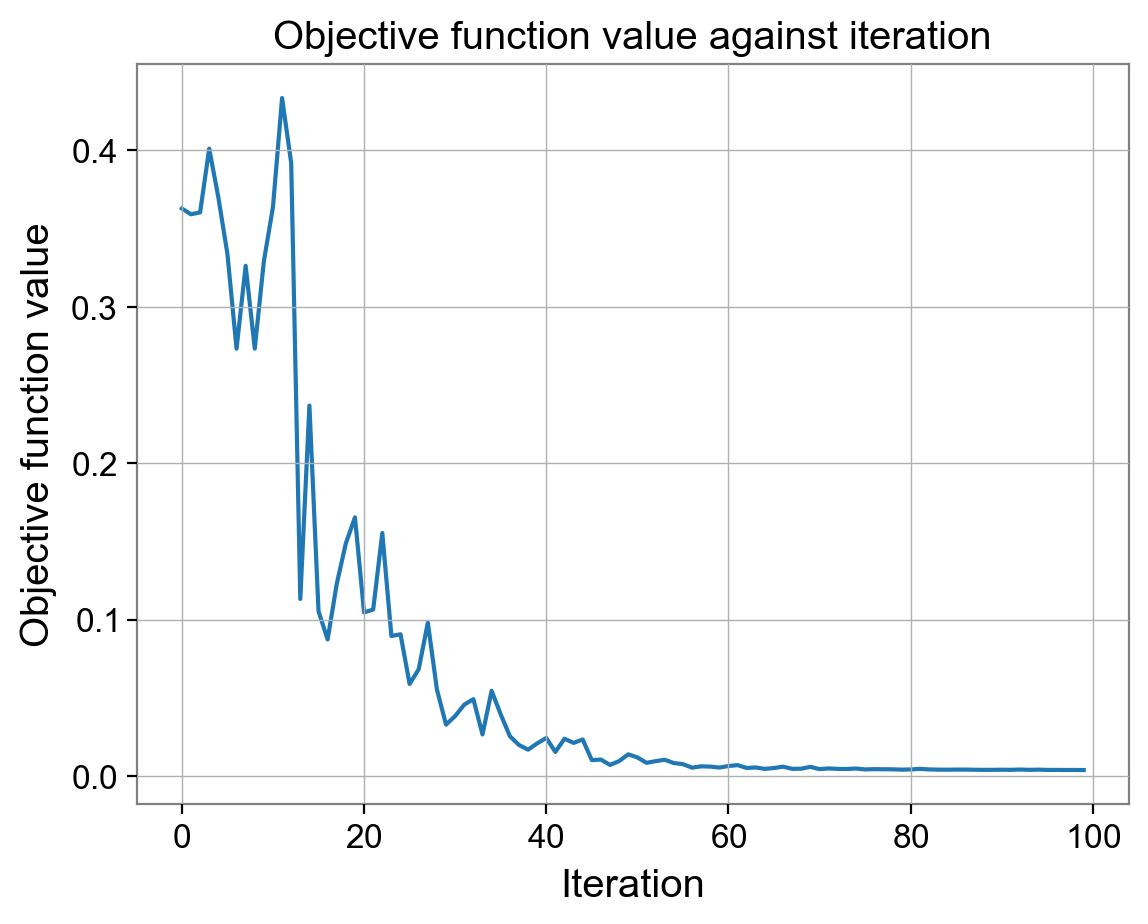

Fit in 93.74 seconds


In [215]:
cost_function = []
parameters2 = optimizationLoop(qnn2, trainingQData, 12)


In [216]:
scoreGW1 = []
scoreGW2 = []
for featureArray in GWQData :
    proba = qnn1(featureArray).forward([], parameters1)[0][1]
    scoreGW1.append(proba)
    proba = qnn2(featureArray).forward([], parameters2)[0][1]
    scoreGW2.append(proba)


In [218]:
score1 = []
score2 = []
for featureArray in NonGWQData :
    proba = qnn2(featureArray).forward([], parameters2)[0][1]
    score2.append(proba)
    proba = qnn1(featureArray).forward([], parameters1)[0][1]
    score1.append(proba)


Text(0.5, 1.0, 'Results of the autoencoder 1')

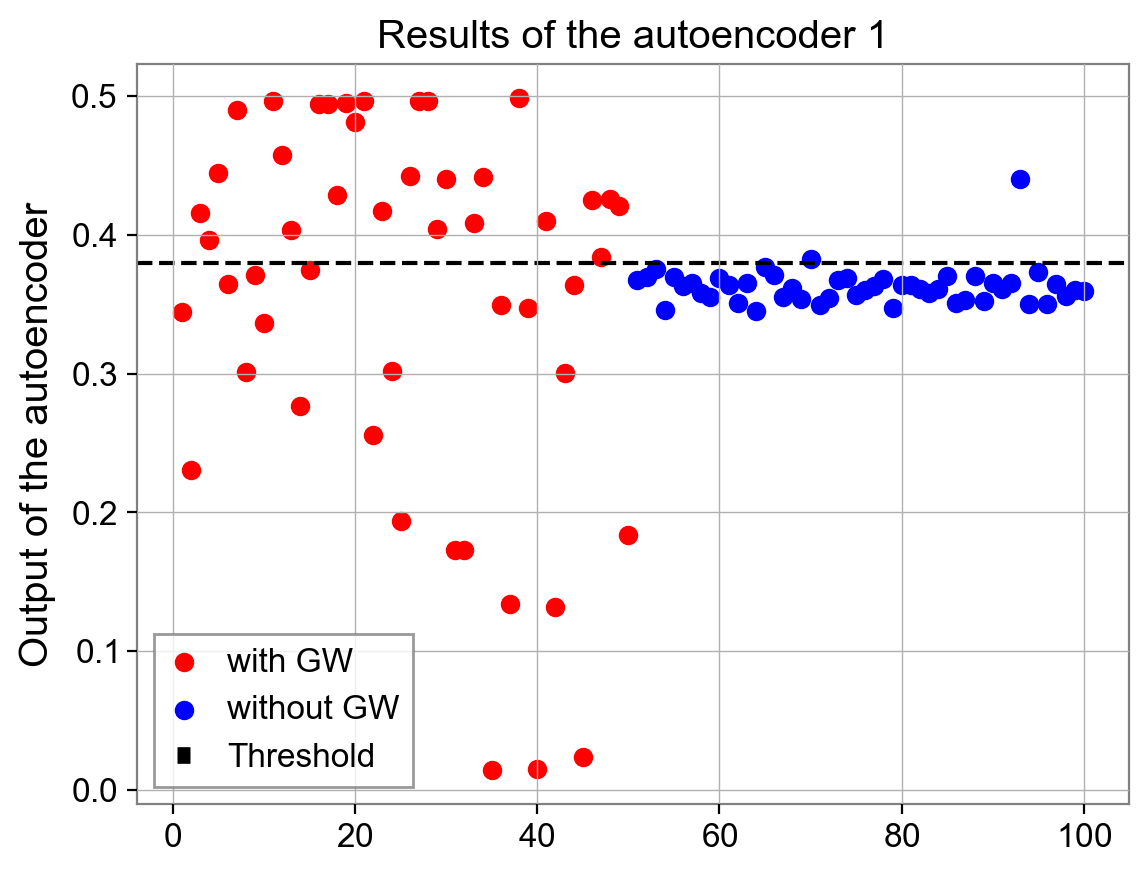

In [225]:
plt.scatter(range(1,51), scoreGW1, c="red", label = "with GW")
plt.scatter(range(51,101), score1, c="blue", label = "without GW")
plt.axhline(y=0.38, color='black', linestyle='--', label='Threshold')
plt.legend()
plt.ylabel("Output of the autoencoder")
plt.title("Results of the autoencoder 1")

For this variational circuit, we achieve 96% correctly recognizing samples with no gravitational waves as such, but only 54% of samples with gravitational waves are flagged as such.

Text(0.5, 1.0, 'Results of the autoencoder 2')

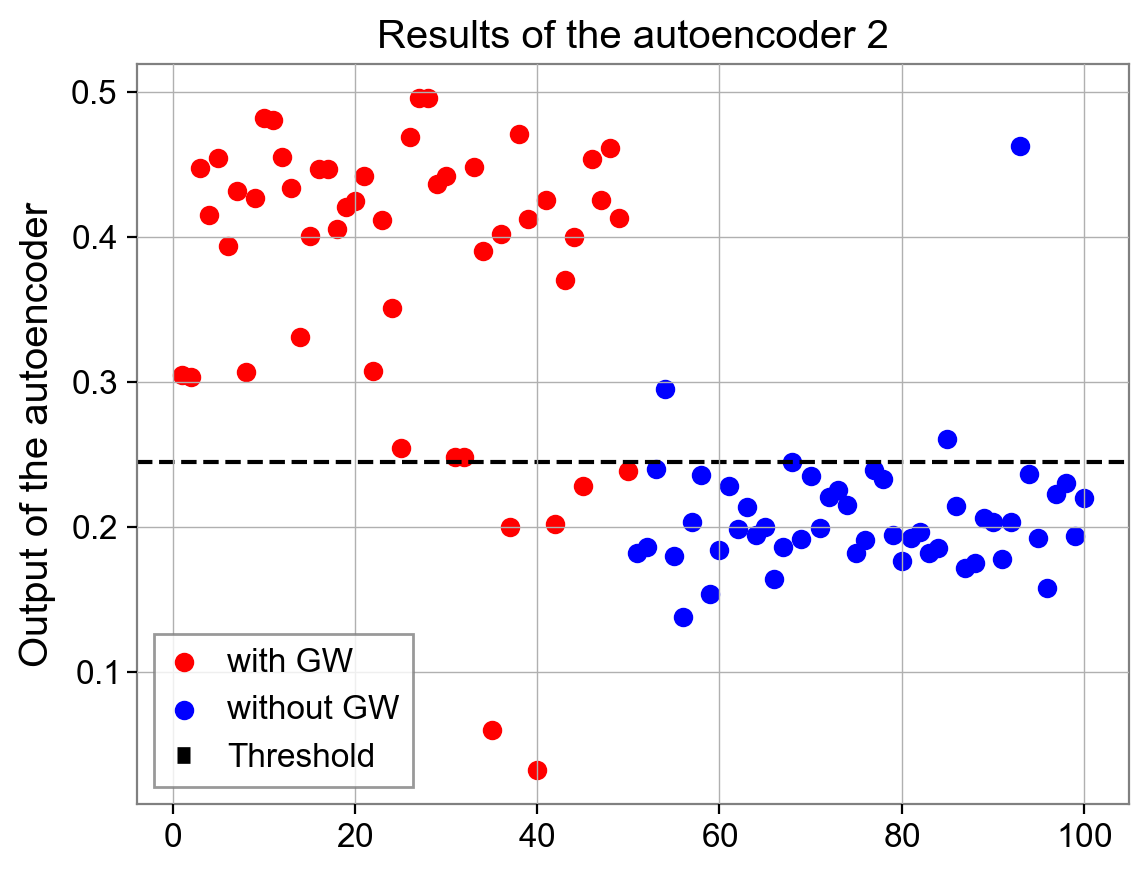

In [230]:
plt.scatter(range(1,51), scoreGW2, c="red", label = "with GW")
plt.scatter(range(51,101), score2,c="blue", label = "without GW")
plt.axhline(y=0.245, color='black', linestyle='--', label='Threshold')

plt.legend()
plt.ylabel("Output of the autoencoder")
plt.title("Results of the autoencoder 2")

In [231]:
gw_ratio = 0
nogw_ratio = 0
for s in scoreGW2 :
    if s > 0.245 :
        gw_ratio += 1
gw_ratio = gw_ratio / 50
for s in score2 :
    if s < 0.245 :
        nogw_ratio += 1
nogw_ratio = nogw_ratio / 50

print("percentage of gw samples correctly classified:" , gw_ratio * 100, "%")
print("percentage of samples without gw correctly classified:", nogw_ratio*100, "%")

percentage of gw samples correctly classified: 88.0 %
percentage of samples without gw correctly classified: 92.0 %


The second circuit achieved much better performance than the first which prioritized entanglement rather than exploring a bigger Hilbert space, thus showing an advantage in using more rotation gates for the construction of the ansatz, although in a setting where errors are taken into account, having a more gates wouldn't amount necessarily to better performance. 

References :

Vishal S. Ngairangbam, Michael Spannowsky, and Michihisa Takeuchi, Anomaly detection in high-energy physics using a quantum autoencoder :

https://arxiv.org/pdf/2112.04958

Quantum Autoencoder with MNIST classification :

https://fullstackquantumcomputation.tech/blog/quantum-autoencoder/

Qiskit tutorial on quantum autoencoders : 

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

Carlos Bravo-Prieto, Quantum autoencoders with enhanced data encoding :

https://arxiv.org/pdf/2010.06599 

O1 Speclines :

https://gwosc.org/o1speclines/ 

GWOSC tutorials :

https://colab.research.google.com/github/gwosc-tutorial/quickview/blob/master/index.ipynb#scrollTo=vNnwYNDnBQWq 

https://gwpy.github.io/docs/stable/examples/signal/gw150914/ 

https://gwpy.github.io/docs/2.1.3/examples/frequencyseries/percentiles/ 





